In [1]:
import tensorflow as tf
import keras
import keras_vggface
from keras_vggface.vggface import VGGFace
# Had to change code in keras vggface to make it work changed model.py line 20 as shown here https://stackoverflow.com/a/71379206
import numpy as np
import matplotlib as mpl
from keras.utils.data_utils import get_file
import keras_vggface.utils
import PIL
import os
import os.path
import matplotlib.pyplot as plt

In [14]:
train_seed = 42
split = 0.2

train_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=8, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


In [15]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2), ])

In [16]:
resnet_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

In [24]:
from keras.layers import Dense, Flatten, Input
from keras_vggface.vggface import VGGFace

num_classes = 4

resnet_base.trainable = False
last_layer = resnet_base.get_layer('avg_pool').output

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = resnet_base(x)
x = Flatten(name='flatten')(x)

out = Dense(num_classes, name='classifier')(x)

custom_resnet_model = keras.Model(inputs, out)

In [18]:
LR = 0.0001

custom_resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [30]:
base_history = custom_resnet_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
15/15 [==============================] - 3s 182ms/step - loss: 9.4321 - accuracy: 0.3167 - val_loss: 10.8463 - val_accuracy: 0.1833
Epoch 2/20
15/15 [==============================] - 3s 181ms/step - loss: 9.4521 - accuracy: 0.2708 - val_loss: 10.9822 - val_accuracy: 0.1833
Epoch 3/20
15/15 [==============================] - 3s 182ms/step - loss: 9.8964 - accuracy: 0.3000 - val_loss: 10.7836 - val_accuracy: 0.1833
Epoch 4/20
15/15 [==============================] - 3s 181ms/step - loss: 9.4963 - accuracy: 0.3125 - val_loss: 10.7804 - val_accuracy: 0.1833
Epoch 5/20
15/15 [==============================] - 3s 181ms/step - loss: 8.8606 - accuracy: 0.2833 - val_loss: 10.9468 - val_accuracy: 0.1833
Epoch 6/20
15/15 [==============================] - 3s 181ms/step - loss: 9.6206 - accuracy: 0.2625 - val_loss: 11.0284 - val_accuracy: 0.1833
Epoch 7/20
15/15 [==============================] - 3s 181ms/step - loss: 9.2197 - accuracy: 0.3083 - val_loss: 10.6237 - val_accuracy: 0.1833

In [ ]:
# plot the history and loss
plt.plot(base_history.history['accuracy'], label='accuracy')
plt.plot(base_history.history['val_accuracy'], label='val_accuracy')
plt.plot(base_history.history['loss'], label='loss')
plt.show()

# Privacy

In [20]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer
import tensorflow_privacy

In [21]:
train_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='training')
val_dataset = keras.utils.image_dataset_from_directory('./Faces', shuffle=True, image_size=(224, 224), batch_size=16, seed=train_seed, validation_split=split, subset='validation')

Found 300 files belonging to 4 classes.
Using 240 files for training.
Found 300 files belonging to 4 classes.
Using 60 files for validation.


In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction=tf.losses.Reduction.NONE)

In [23]:
noise_multiplier = 1.1
l2_norm_clip = 5
num_microbatches = 16
learning_rate = 0.0001

# optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
#     l2_norm_clip=l2_norm_clip,
#     noise_multiplier=noise_multiplier,
#     num_microbatches=num_microbatches,
#     learning_rate=learning_rate
# )

optimizer = tensorflow_privacy.DPKerasAdamOptimizer(
    l2_norm_clip=l2_norm_clip,
    noise_multiplier=noise_multiplier,
    num_microbatches=num_microbatches,
    learning_rate=learning_rate
)

In [25]:
LR = 0.0001

custom_resnet_model.compile(optimizer=optimizer,
    loss = loss,
    metrics=['accuracy'])

In [26]:
history = custom_resnet_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20


2023-05-03 15:09:33.112748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 8.7016 - accuracy: 0.1458

2023-05-03 15:09:36.981874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 7s 269ms/step - loss: 8.7016 - accuracy: 0.1458 - val_loss: 10.7517 - val_accuracy: 0.0500
Epoch 2/20
15/15 [==============================] - 3s 187ms/step - loss: 9.9877 - accuracy: 0.1125 - val_loss: 10.4832 - val_accuracy: 0.0833
Epoch 3/20
15/15 [==============================] - 3s 183ms/step - loss: 9.2462 - accuracy: 0.1292 - val_loss: 10.6463 - val_accuracy: 0.0833
Epoch 4/20
15/15 [==============================] - 3s 182ms/step - loss: 9.2621 - accuracy: 0.2042 - val_loss: 10.9009 - val_accuracy: 0.1000
Epoch 5/20
15/15 [==============================] - 3s 183ms/step - loss: 8.2397 - accuracy: 0.2333 - val_loss: 10.7036 - val_accuracy: 0.1333
Epoch 6/20
15/15 [==============================] - 3s 182ms/step - loss: 8.7387 - accuracy: 0.2167 - val_loss: 10.7119 - val_accuracy: 0.1333
Epoch 7/20
15/15 [==============================] - 3s 180ms/step - loss: 8.3267 - accuracy: 0.2250 - val_loss: 10.1563 - val_accuracy: 0.1500
Epoch 8/20

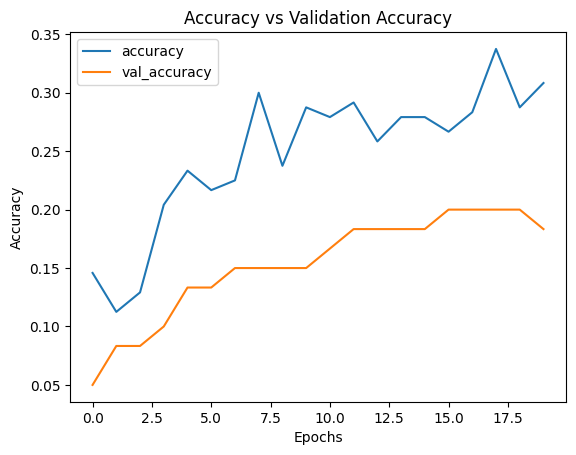

In [29]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')

plt.title("Accuracy vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()